# Interpretable Clustering

In [ ]:
!conda env create -n xai_clustering --file requirements.yml

Use this conda environment as your jupyter notebook kernel

In [1]:
!wandb login

zsh: Can't add module parameter `commands': parameter already exists
wandb: Currently logged in as: ryerson-dsl (use `wandb login --relogin` to force relogin)


Go to `interpretable_ts_clustering/configs/defaults.py` and change PROJECT_NAME and WANDB_ENTITY to your own

Change <repo_location> accordingly in cell below

In [ ]:
cwd = "<repo_location>/interpretable_ts_clustering"
os.chdir(cwd)

In [14]:
from interpretable_ts_clustering.train.train_clustering import train_clustering
from interpretable_ts_clustering.train.train_classification import train_classification
from interpretable_ts_clustering.configs.defaults import Globs
import json 
import os 
import numpy as np 
import wandb

In [3]:
n_clusters = 5 
clustering_model = "kmeans"
dataset = "electricity_hourly"
clustering_init = None 
stage = "testing"
plot_min_samples = 5
plot_max_samples = 20

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ryerson-dsl (use `wandb login --relogin` to force relogin)


{'DATASET': 'electricity_hourly', 'RANDOM_SEED': 5, 'STAGE': 'testing', 'BALANCING': None, 'CLUSTERING_MODEL': 'kmeans', 'N_CLUSTERS': 5, 'NUM_CLASSES': 5, 'CLUSTER_INIT': None, 'PLOT_MIN_SAMPLES': 5, 'PLOT_MAX_SAMPLES': 20, 'feat_config': None}
Data shape: (336, 168)
/Users/nicholasprayogo/code/interpretable_TS_clustering/nicholas/published/interpretable_ts_clustering/wandb/run-20220626_000535-2sh2j13k/files
Counter({0: 155, 1: 80, 4: 47, 2: 31, 3: 23})



calinski_harabasz_score,▁
davies_bouldin_score,▁
inertia,▁
silhouette_score,▁
calinski_harabasz_score,90.79291
davies_bouldin_score,1.64535
inertia,1397.03029
silhouette_score,0.24157


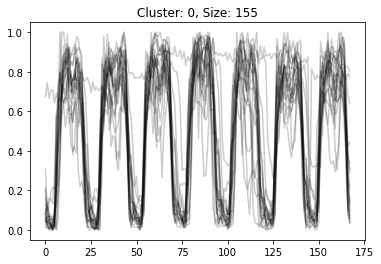

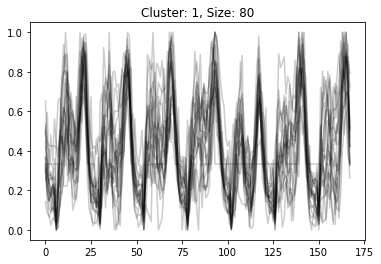

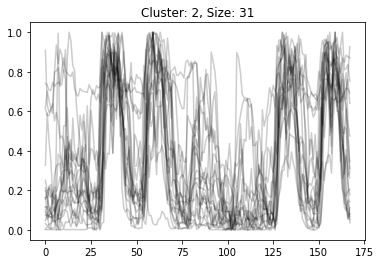

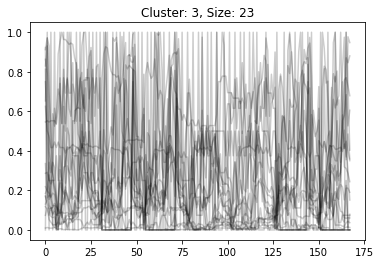

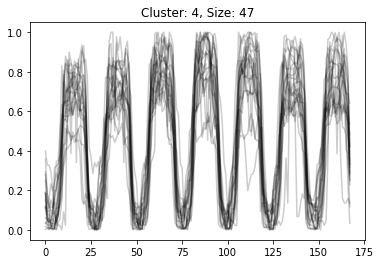

In [7]:
cluster_model_dict_path = "../data/cluster_models.json"
with open(cluster_model_dict_path, "r") as f:
    cluster_models_dict = json.load(f)

cluster_model_key = f"{dataset}_{clustering_model}_{n_clusters}_{clustering_init}"

if cluster_model_key not in cluster_models_dict.keys():
    config = dict(
        DATASET= dataset,
        RANDOM_SEED=5,
        STAGE = stage 
    )
    config["BALANCING"] = None 
    config["CLUSTERING_MODEL"] = clustering_model
    config["N_CLUSTERS"] = n_clusters
    config["NUM_CLASSES"] = n_clusters
    config["CLUSTER_INIT"] = None 
    config["PLOT_MIN_SAMPLES"]= plot_min_samples
    config["PLOT_MAX_SAMPLES"] = plot_max_samples
    config["feat_config"] = None  
    config_wandb, cluster_model_id, run_dir = train_clustering(config)

    cluster_models_dict[cluster_model_key] = cluster_model_id
                    
    with open(cluster_model_dict_path, "w") as f:
        json.dump(cluster_models_dict, f)


In [8]:
balancing = None
start_epoch = 250 
patience = 50
monitor = "val_accuracy"
min_delta = 0
start_epoch = 250 
feat_config = None 
class_model_name = "xgb"


In [9]:
config["BALANCING"] = balancing
config["CLUSTERING_MODEL"] = clustering_model
config["N_CLUSTERS"] = n_clusters
config["NUM_CLASSES"] = n_clusters
config["CLUSTER_INIT"] = clustering_init
config["MIN_DELTA"] = min_delta
config["PATIENCE"] = patience
config["feat_config"] = feat_config 
config["PLOT_MIN_SAMPLES"]= plot_min_samples
config["PLOT_MAX_SAMPLES"] = plot_max_samples
config["START_EPOCH"] = start_epoch
config["MONITOR"] = monitor 

In [10]:
if class_model_name == "nndtw":
    config["N_NEIGHBORS"] = 5
    config["KNN_METRIC"] = "minkowski" 
    
if dataset != "trace":
    dataset_key = dataset 
    cluster_model_key = f"{dataset_key}_{clustering_model}_{n_clusters}_{clustering_init}"
    if (cluster_model_key in cluster_models_dict.keys()):
        cluster_model_id = cluster_models_dict[cluster_model_key]
        cluster_filename = 'clusters.npy'
        if os.path.exists(cluster_filename):
            os.remove(cluster_filename)
        cluster_path = wandb.restore(
        cluster_filename, run_path=f"{Globs.WANDB_ENTITY}/{Globs.PROJECT_NAME}/{cluster_model_id}")
        clusters = np.load(cluster_path.name)
        
    else:
        raise Exception(f"no cluster model for {cluster_model_key}")
        
else: 
    cluster_model_id = "trace_default"
    with open('data/trace/clusters.npy', 'rb') as f:
        clusters = np.load(f)

class_model_config = config.copy() 
class_model_config['CLASSIFICATION_MODEL'] = class_model_name
class_model_config['cluster_model_id'] = cluster_model_id

class_model = train_classification(class_model_config, clusters)

Data shape: (336, 168), (336,)
Data shape after remove low freq: (336, 168), (336,)
[00:05:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.



acc,▁
f1,▁
fscore,▁
macro_f1,▁
micro_f1,▁
precision,▁
recall,▁
acc,0.91089
f1,0.9126
fscore,0.9126
macro_f1,0.86092


In [11]:
class_model

Data shape: (336, 168), (336,)


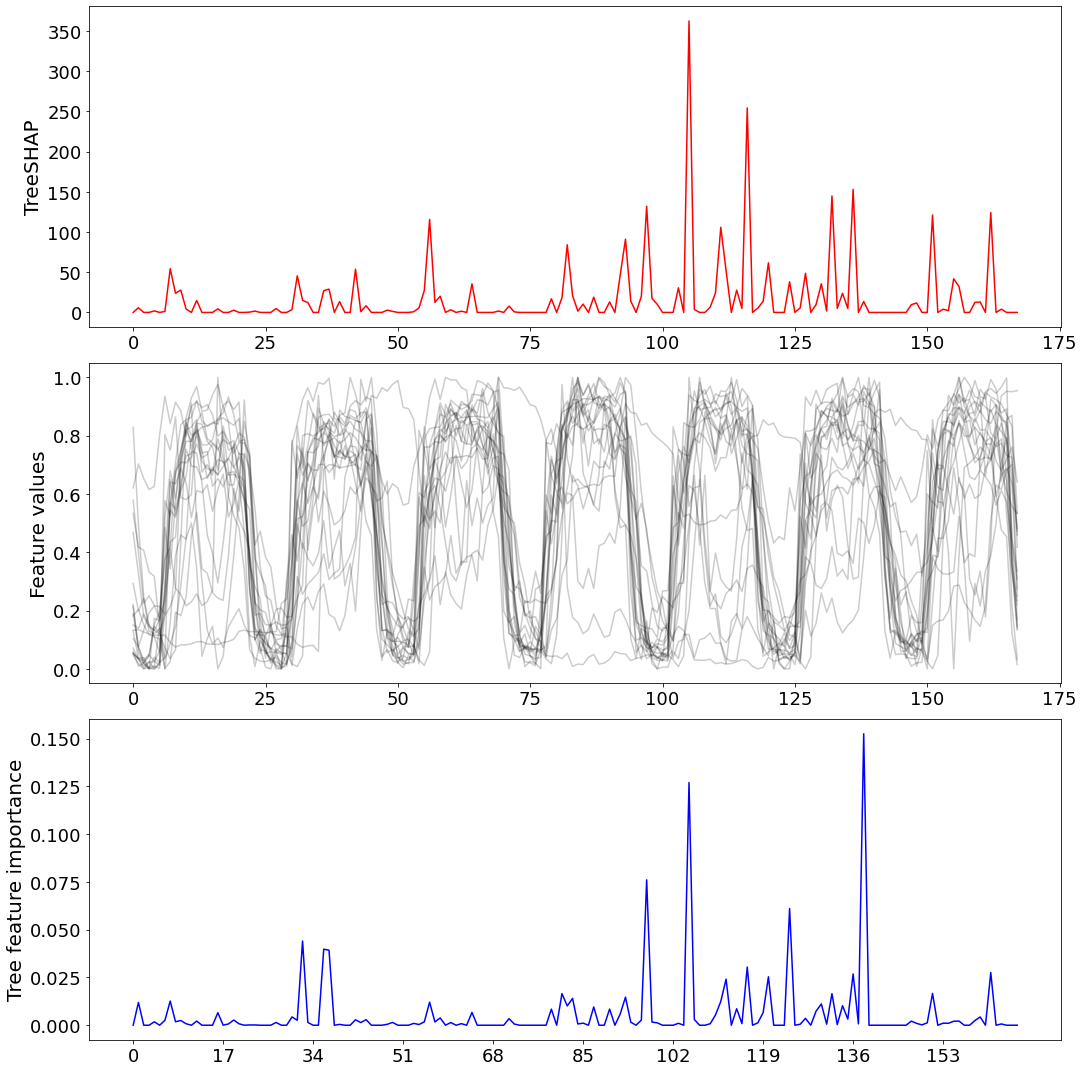

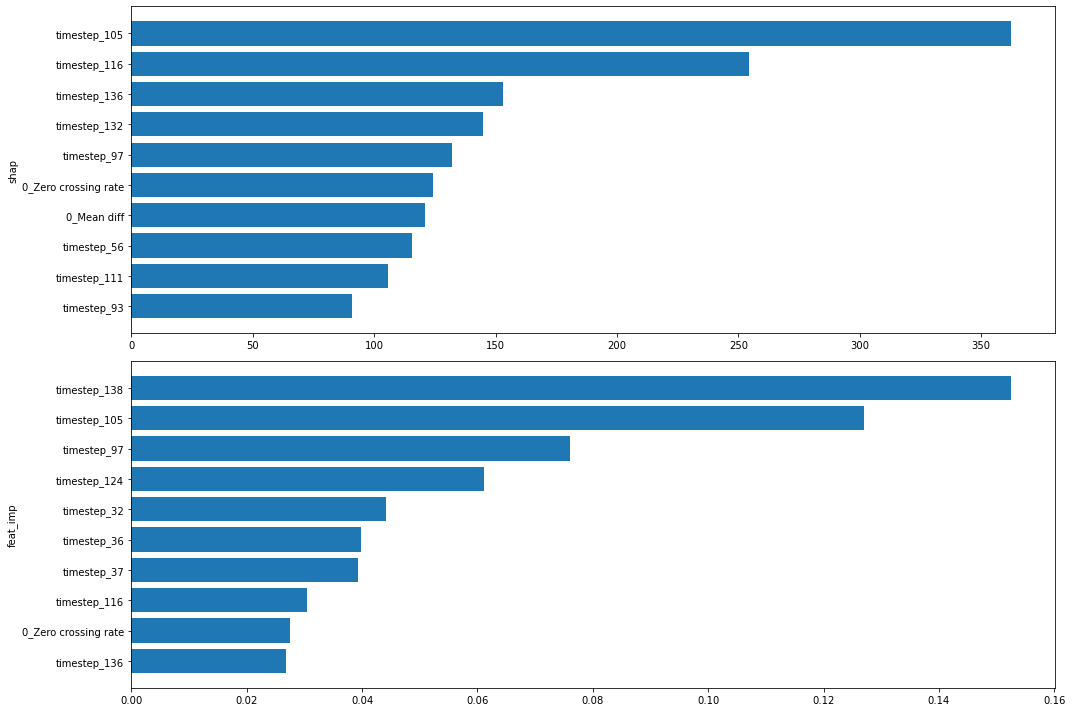

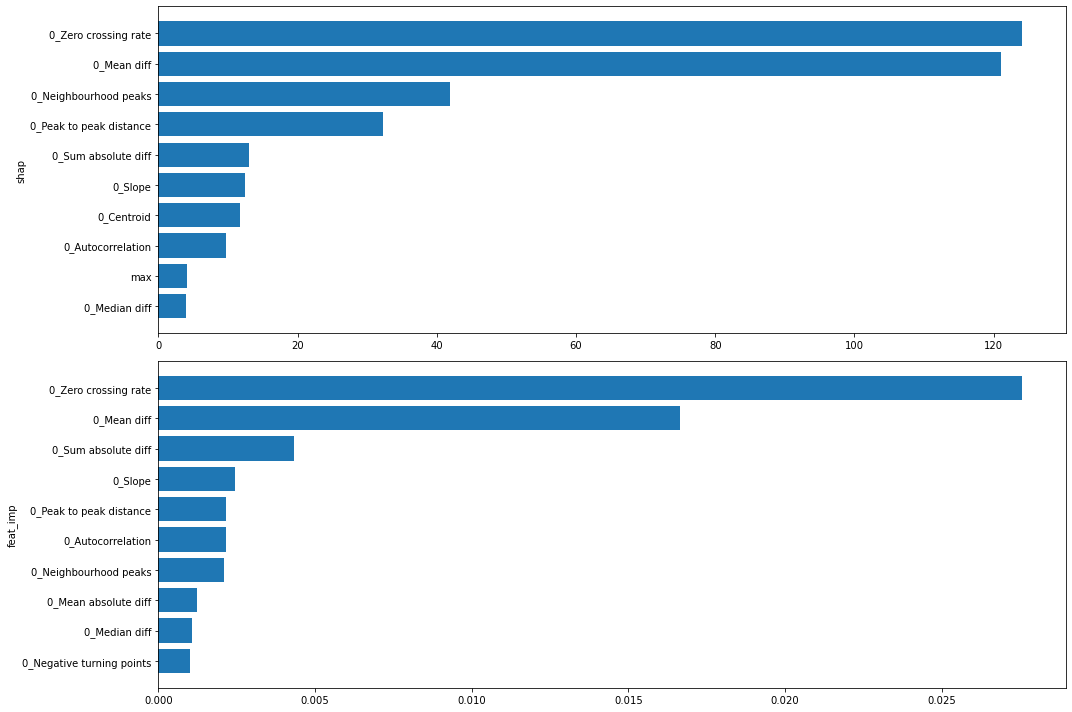

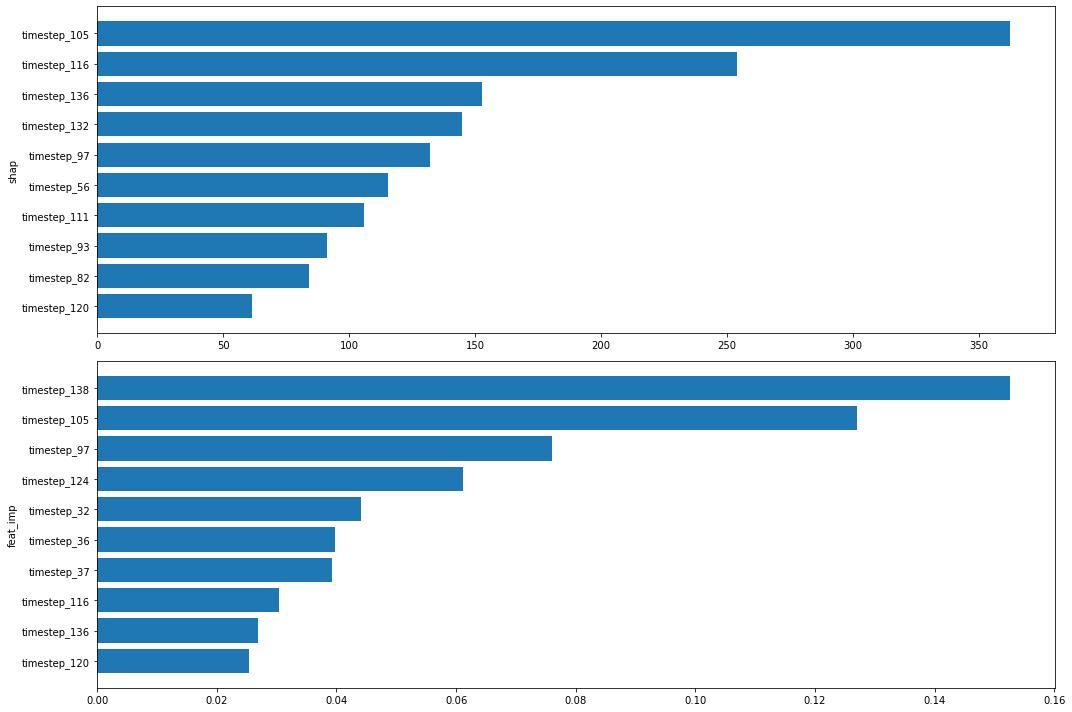

In [13]:
from interpretable_ts_clustering.data.loader import data_loader
from sklearn.model_selection import train_test_split
from interpretable_ts_clustering.visualization.xai import plot_xgb, plot_fcn

extra_features = np.array(['0_Absolute energy', '0_Area under the curve', '0_Autocorrelation',
       '0_Centroid', '0_Entropy', '0_Mean absolute diff', '0_Mean diff',
       '0_Median absolute diff', '0_Median diff', '0_Negative turning points',
       '0_Neighbourhood peaks', '0_Peak to peak distance',
       '0_Positive turning points', '0_Signal distance', '0_Slope',
       '0_Sum absolute diff', '0_Total energy', '0_Zero crossing rate', 'mean',
       'max', 'min', 'variance', 'std_dev'])

X, y = data_loader[class_model_config['DATASET']](class_model_config), clusters

print(f"Data shape: {X.shape}, {y.shape}")
train_x, test_x, train_y, test_y = train_test_split(X, y,
    test_size=0.2, random_state=class_model_config['RANDOM_SEED'])

class_model_config["HISTORY_SIZE"] = X.shape[1]

save_dir = f"../results/{dataset}"

os.makedirs(save_dir, exist_ok=True)

if class_model_name == "xgb": 
    plot_xgb(train_x, class_model_config, class_model, save_dir, extra_features)
elif class_model_name == "fcn":
    plot_fcn(train_x, train_y, class_model_config, class_model, save_dir, extra_features)
        
        